In [1]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
import math
import csv
from scipy.optimize import minimize, Bounds

V_const = 10**14

class Const:
    #eta = 1e-3
    #rho_f = 1000

    eta = 0.36e-3 # Viscosity of acetone
    rho_f = 789  # Density of acetone
    # K = 10e-6
    T = 293
    k_b = scipy.constants.k
    runs = 10000
    # V = 10**6
    BaTi_density = 4200

fits_r = []
fits_v = []
fits_k = []
high_passes = np.linspace(90,130,20)
bin_number = 30
velocity_order = 8
filename = r"C:\Users\mct2723\Desktop\Dielectric Data\Third Good Set\10"
offset = 237
num_files = 1
traces_per_file = 5
sampling_rate = 200000000
tikonov = True
stop = .2e-3

In [2]:
def MSD_fitting_func(t,m, K, r, V):
    trap_const = K
    use_mass = m
    m_f = 4/3*np.pi*r**3*Const.rho_f
    t_k = (6 * np.pi * r * Const.eta)/trap_const
    t_f = (Const.rho_f*r**2)/Const.eta
    t_p = m/(6 * math.pi * r * Const.eta)
    # find roots
    # a * z^4 + b * z^3 + c * z^2 + d * z + e = 0
    a = t_p
    b = -1*np.sqrt(t_f)
    c = 1
    d = 0
    e = 1 / t_k

    # Coefficients array for the polynomial equation
    coefficients = [a, b, c, d, e]

    # Find the roots
    roots = np.roots(coefficients)

    term_1 = scipy.special.erfcx(roots[0]*np.sqrt(t)) / (roots[0]*(roots[0] - roots[1])*(roots[0] - roots[2])*(roots[0] - roots[3]))
    term_2 = scipy.special.erfcx(roots[1]*np.sqrt(t)) / (roots[1]*(roots[1] - roots[0])*(roots[1] - roots[2])*(roots[1] - roots[3]))
    term_3 = scipy.special.erfcx(roots[2]*np.sqrt(t)) / (roots[2]*(roots[2] - roots[1])*(roots[2] - roots[0])*(roots[2] - roots[3]))
    term_4 = scipy.special.erfcx(roots[3]*np.sqrt(t)) / (roots[3]*(roots[3] - roots[1])*(roots[3] - roots[2])*(roots[3] - roots[0]))

    D = Const.k_b*Const.T / (6*np.pi*Const.eta*a)

    return np.real(V*(2*Const.k_b*Const.T / trap_const+ 2*Const.k_b*Const.T/(m)*(term_1+term_2+term_3+term_4)))


def save_results_to_csv(traces, output_file):

    trace_headers = [f"Trace {i + 1}" for i in range(len(traces))]

    # Write data to CSV
    with open(output_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)

        writer.writerow(trace_headers)

        max_trace_length = max(len(trace) for trace in traces)

        for i in range(max_trace_length):
            row = []
            for trace in traces:
                if i < len(trace):
                    row.append(trace[i])
                else:
                    row.append("")
            writer.writerow(row)

    print(f"Data saved to {output_file}")

def MSD_fitting_const_rho(t, MSD_data, K_guess, a_guess, V_guess, m_guess, bounds=None):
    initial_guess = [V_guess, a_guess, K_guess]
    def least_squares_func(x):
        # Fit for mass only, using K and a as constants
        K = x[2] / 10**6

        V = x[0] *V_const
        a = x[1]*10**-6
        m = 4/3*np.pi*a**3*(Const.BaTi_density + Const.rho_f/2)
        msd_model = MSD_fitting_func(t, m, K, a, V)
        # Least squares: minimize the sum of squared differences
        print_negative_indices(np.real(MSD_data), "data")
            # print(f"K: {K}, V: {V}, a: {a}, m: {m} ")
        print_negative_indices(np.real(msd_model), "model")
            # print(f"K: {K}, V: {V}, a: {a}, m: {m} ")

        return np.sum((np.log(np.real(MSD_data)) - np.log(np.real(msd_model))) ** 2)

    optimal_parameters = scipy.optimize.minimize(least_squares_func, initial_guess, bounds=bounds, method="Nelder-Mead", options={'maxiter':1000,'xatol': 1e-15, 'fatol': 1e-15})
    return optimal_parameters

def print_negative_indices(arr, str):
    """Prints the indices of negative elements in an array.

    Args:
        arr: A list of numbers.
    """
    for i in range(len(arr)):
        if arr[i] < 0:
            print(f"index {i} is less than zero." + " " + str)
            return True


In [3]:
import os
from nptdms import TdmsFile

def check_and_load_or_process(offset, *args,):
    results = process_folder(offset, *args)
    # Returns a list of args, and traces
    return results

def process_folder(offset, folder_name, data_col, num_traces, traces_per):
    results = []
    for i in range(num_traces):
        print("Reading ", folder_name, str(i))
        print("data_col ", data_col)
        for j in range(traces_per):
            result = process_file(folder_name, i, data_col, j, offset=offset)
            if result:
                results.append(result)
    return results

def process_file(folder_name, trace_num, data_col, trace_idx, offset):
    trace_num = trace_num + offset
    file_path = os.path.join(folder_name, "iter_" + str(trace_num) + ".tdms")
    series, args = read_tdms_file(file_path, data_col, trace_idx)

    return {
        "series": series,
        "args": args
    }
def read_tdms_file(file_path, data_col, trace_idx):
    tdms_file = TdmsFile.read(file_path)
    sample_rate = tdms_file["main"].properties.get("r", None)
    print("Sample rate is " + str(sample_rate))
    series = tdms_file["main"][data_col + "_" + str(trace_idx)]
    track_len = len(series.data)
    config_args = {
        "sampling_rate": sample_rate,
        "track_len": track_len
    }

    return series[:], config_args

def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size

    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    ret = np.mean(series.reshape(-1, bin_size), axis=1)
    return ret

def compute_stationary_msd(time_trace, dt):
    n = len(time_trace)
    msd = np.zeros(n)  # Allocate array for MSD
    lag_times = np.arange(1, n, 1) * dt  # Calculate lag times

    for tau in np.array(range(n-1))+1:
        displacements = time_trace[tau:] - time_trace[:n - tau]
        msd[tau] = np.mean(displacements**2)
    msd[0] = np.average(time_trace**2)
    return msd[1:], lag_times

def compute_stationary_msd_fast(time_trace, dt):
    n = len(time_trace)
    msd = np.zeros(n)  # Allocate array for MSD
    lag_times = np.arange(1, n, 1) * dt  # Calculate lag times

    for tau in np.array(range(1, n, 1)):
        displacements = time_trace[tau:] - time_trace[:n - tau]
        msd[tau] = np.mean(displacements**2)
    msd[0] = np.average(time_trace**2)
    return msd[1:], lag_times


def j_msd(signal, lags):
    MSDs = np.zeros(len(lags))
    ls = lags
    for i in range(1, len(ls)):
        counter = 0
        #for j in range(len(signal)-ls[len(ls)-1]-1):
        for j in range(10000):
            MSDs[i] += (signal[j] - signal[ls[i]+j])**2
            counter+=1

        MSDs[i] /= counter
    MSDs[0] = np.average(signal**2)
    return MSDs

def low_freq_fit(f):
    C = 1 / (10**-6*1000)
    x_c = 1j*f*2*np.pi
    #A = 4000
    A = 4.66624990e+03
    Sallen_key = x_c**2 / (x_c**2 + A*x_c + 1.76813086e+07/3)
    RC_high_pass = x_c / (x_c +C)
    return np.abs(Sallen_key)

def apply_transfer(freq, response):
    # df = pd.read_csv(r"C:\Users\mcthu\OneDrive\Desktop\Lab Data\no_filter_response.txt")
    # freqs = np.array(df[df.keys()[0]])
    # print(freqs.max())
    # print(freqs.min())
    # r = np.array(df[df.keys()[1]])
    # # Debug: Check for zeros in r
    # if np.any(r == 0):
    #     print("Warning: Interpolation data contains zeros in the response column.")
    #
    # interpolation = scipy.interpolate.interp1d(freqs, r, fill_value = "extrapolate")


    def low_freq_fit2(f):
        C = 1 / (10**-6*1000)
        x_c = 1j*f*2*np.pi
        #A = 4000
        A = 4.66624990e+03
        Sallen_key = x_c**2 / (x_c**2 + A*x_c + 1.76813086e+07/3)
        RC_high_pass = x_c / (x_c +C)
        return np.abs(Sallen_key)

    print(low_freq_fit2(freq)[low_freq_fit2(freq) <= 0])

    ret = np.concatenate([[1], np.array(response[1:]) / np.sqrt(low_freq_fit2(freq)[1:])])
    return ret



step time is1.5e-07
Reading  C:\Users\mct2723\Desktop\Dielectric Data\Third Good Set\10 0
data_col  X
Sample rate is 200000000.0
Sample rate is 200000000.0
Sample rate is 200000000.0
Sample rate is 200000000.0
Sample rate is 200000000.0
trace X


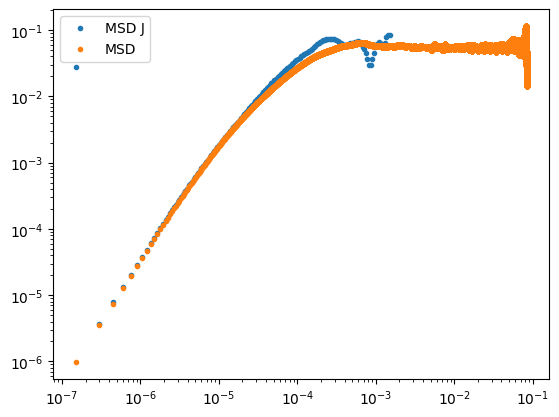

trace X


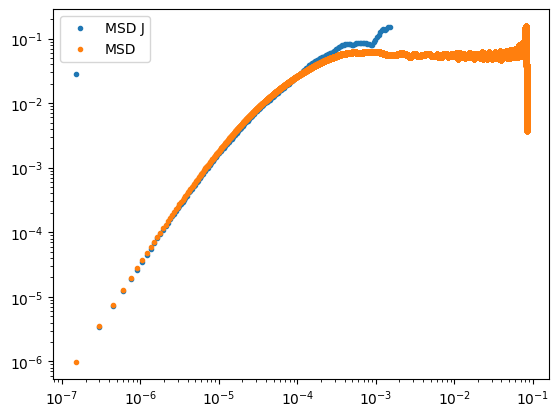

trace X


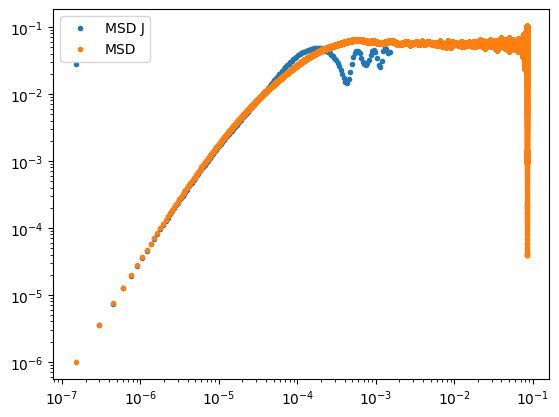

trace X


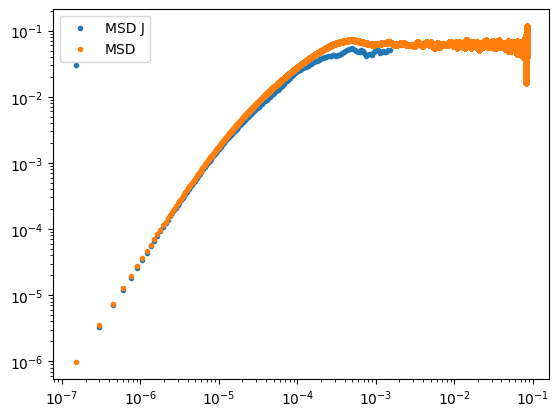

trace X


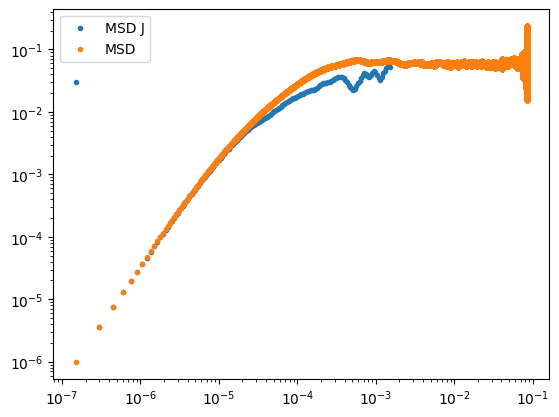

1333
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model


C:\Users\mct2723\AppData\Local\Temp\ipykernel_47784\4012727240.py:71: RuntimeWarning: invalid value encountered in log
  return np.sum((np.log(np.real(MSD_data)) - np.log(np.real(msd_model))) ** 2)


index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
First high pass done
trace X


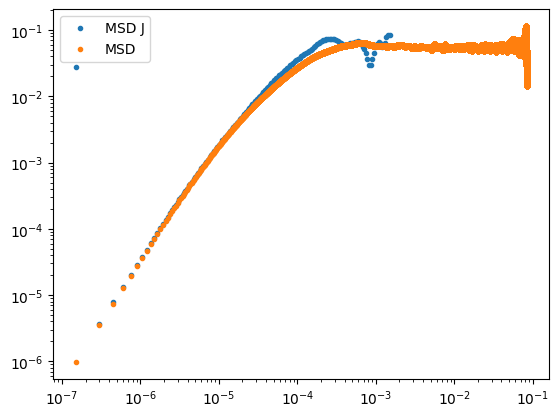

trace X


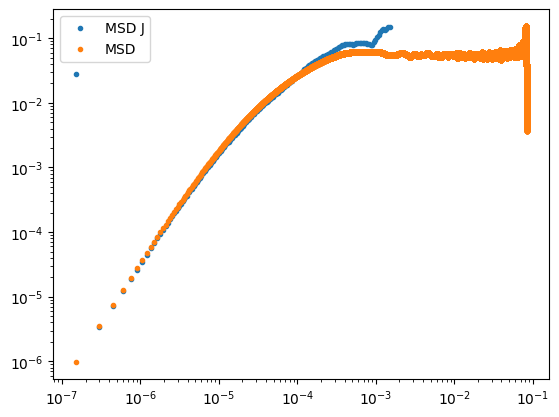

trace X


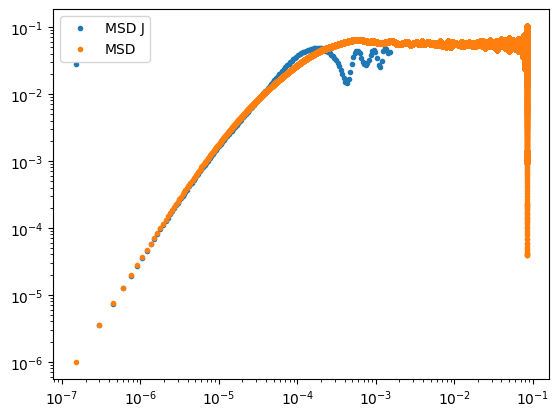

trace X


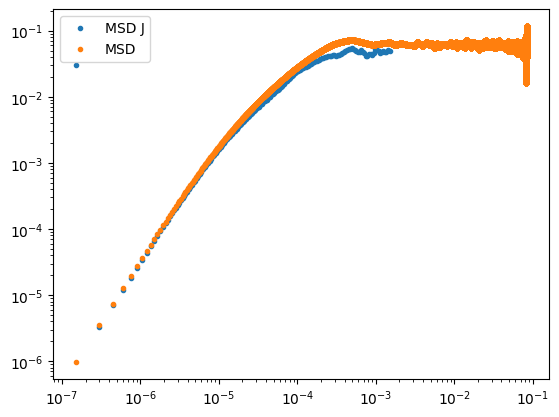

trace X


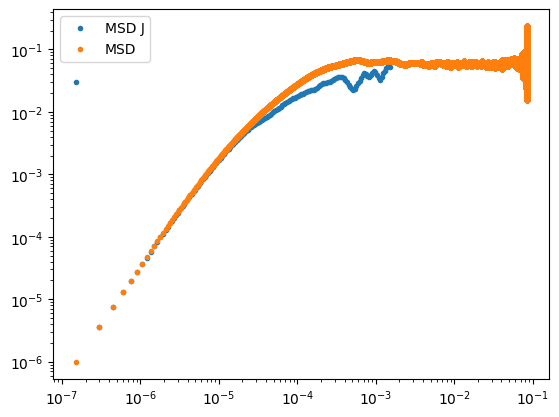

1333
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
First high pass done
trace X


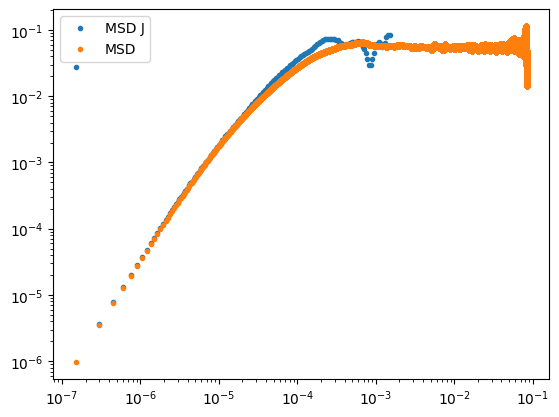

trace X


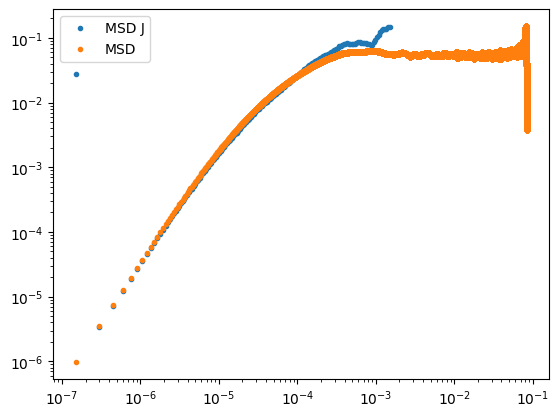

trace X


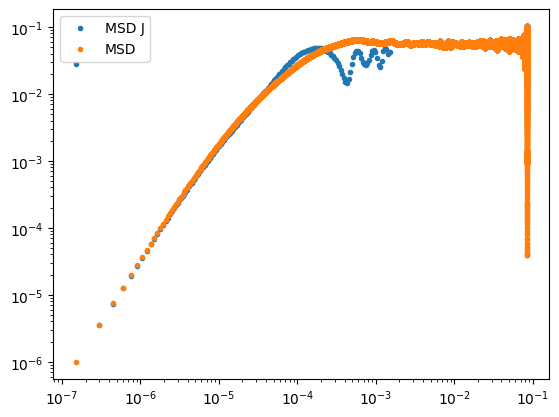

trace X


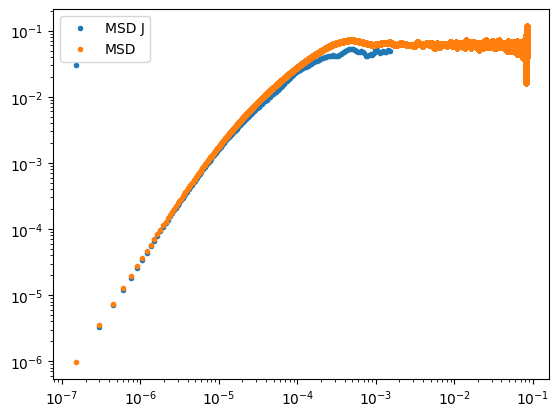

trace X


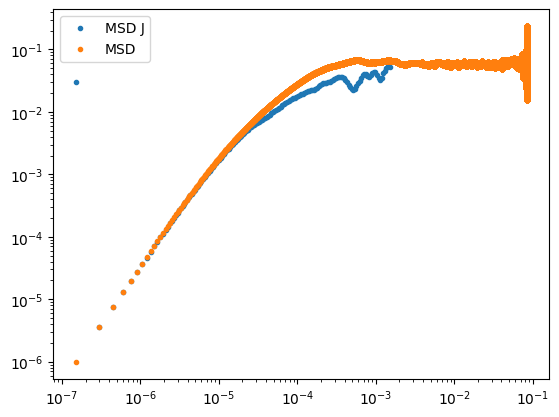

1333
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
First high pass done
trace X


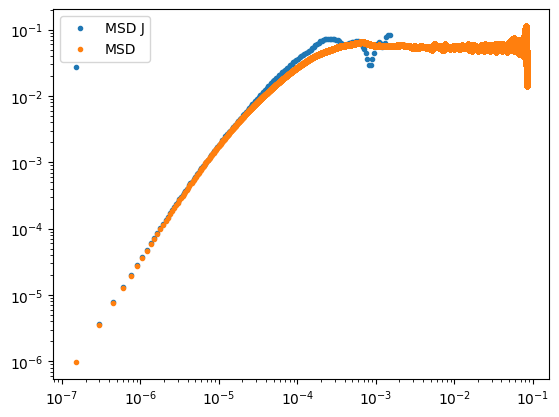

trace X


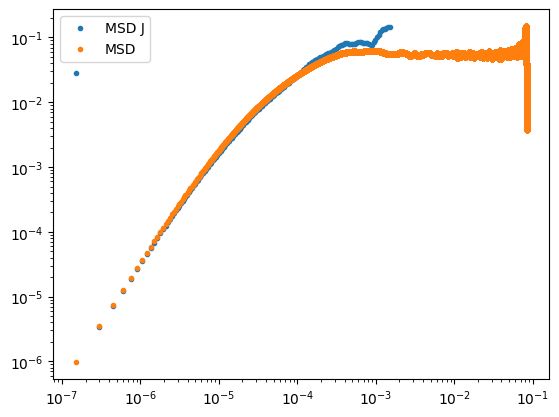

trace X


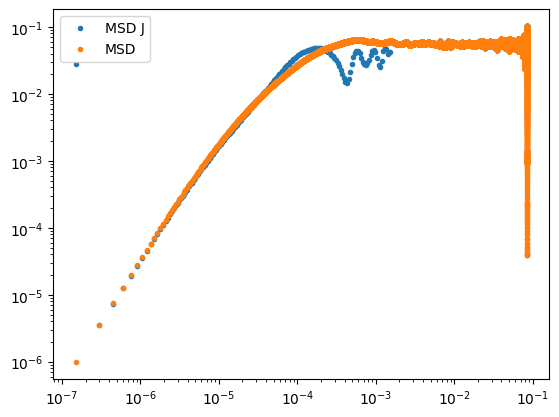

trace X


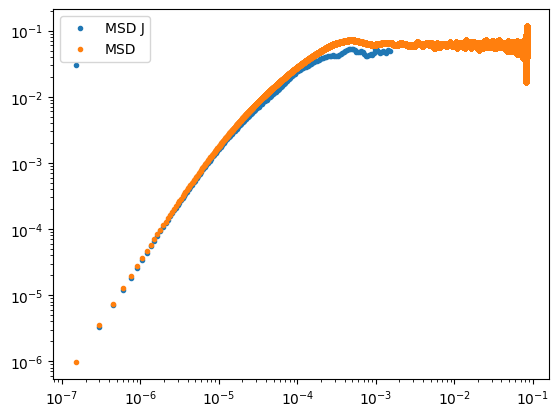

trace X


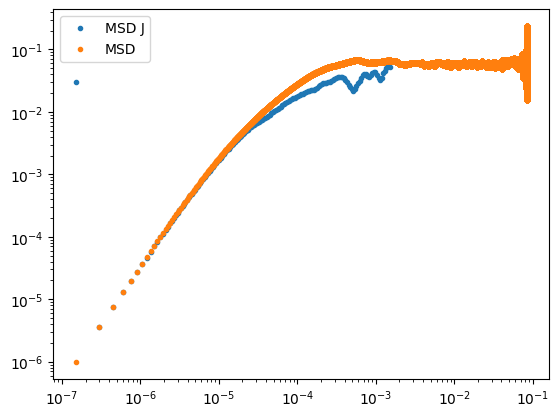

1333
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
First high pass done
trace X


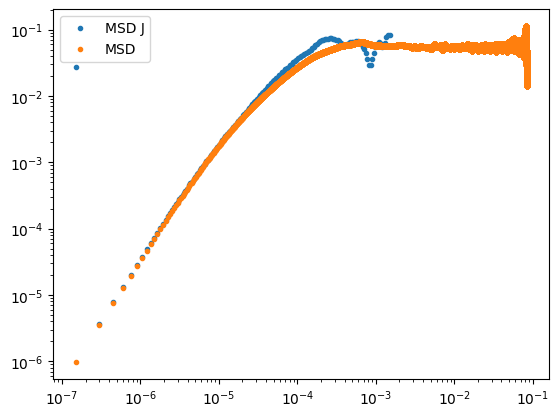

trace X


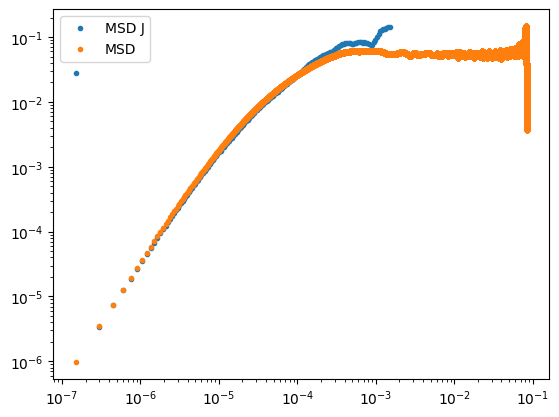

trace X


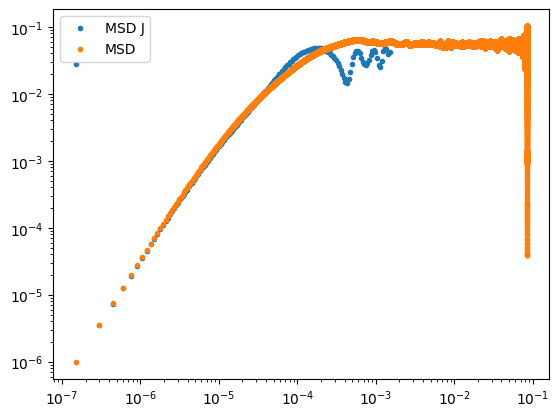

trace X


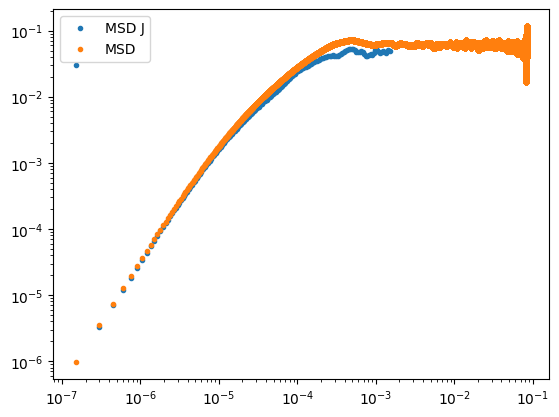

trace X


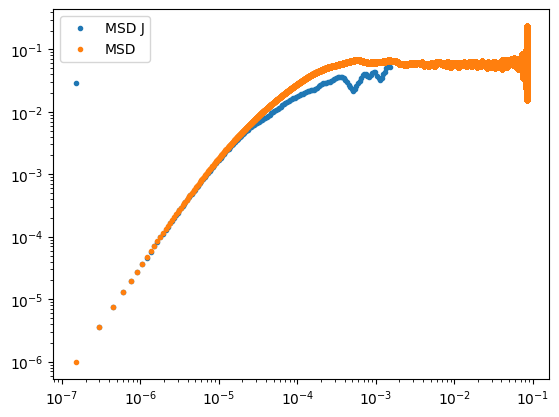

1333
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
First high pass done
trace X


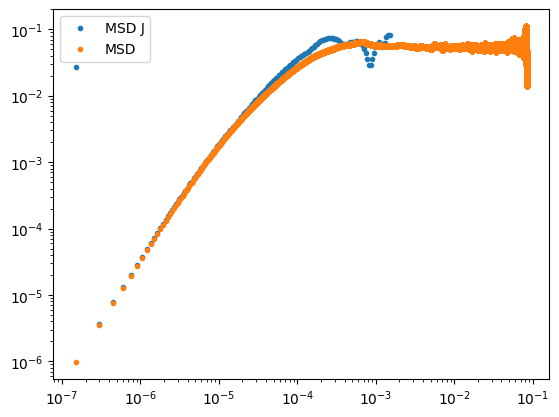

trace X


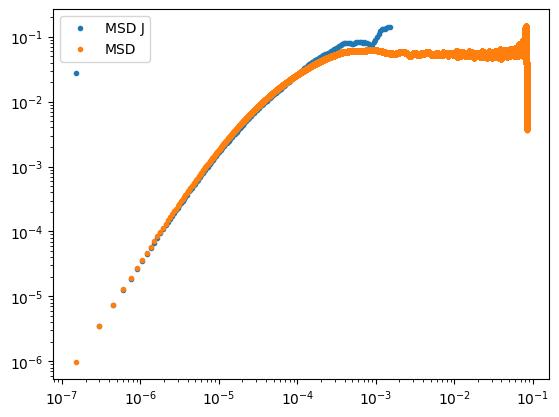

trace X


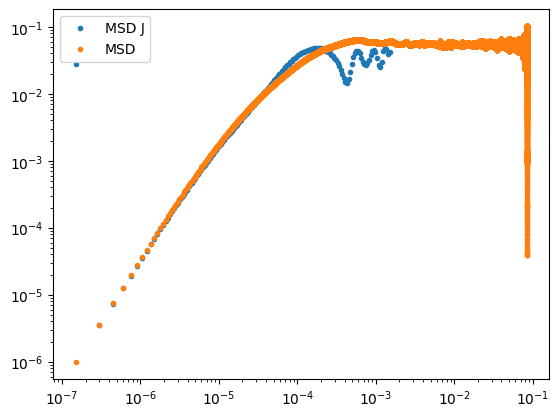

trace X


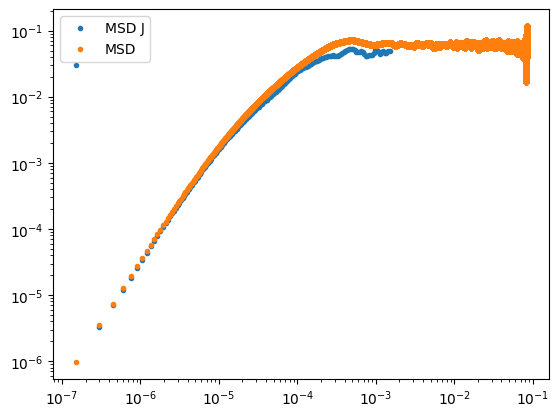

trace X


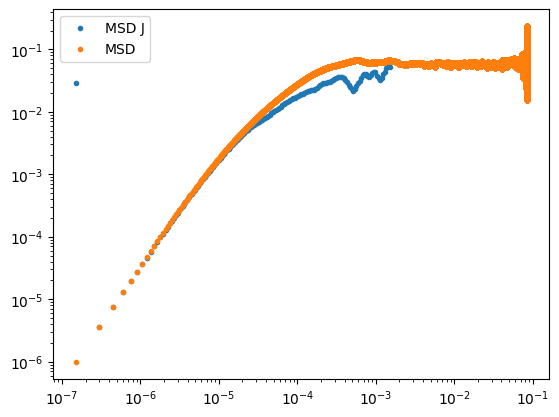

1333
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model
First high pass done
trace X


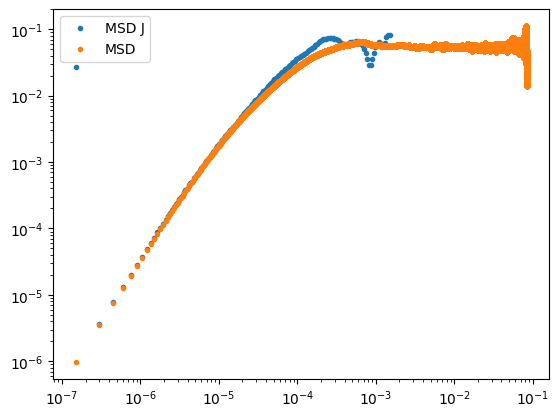

trace X


KeyboardInterrupt: 

In [4]:


print("step time is" + str(bin_number/sampling_rate))

traces = check_and_load_or_process(offset, filename, "X", num_files, traces_per_file)
times = np.arange(0, len(traces[0]['series']))* (1/sampling_rate)

for high_pass in high_passes:
    transfered_traces = []

    if tikonov:
        lda = np.abs(low_freq_fit(high_pass))
        for trace in traces:
            # apply the transfer and convert back
            freq_domain_data = scipy.fft.fft(trace['series'])
            frequencies = scipy.fft.fftfreq(len(trace['series']), times[1] - times[0])
            transfer = low_freq_fit(frequencies)

            freq_domain_data_transfer = (freq_domain_data*np.conj(transfer))/(np.real(transfer)**2 + np.imag(transfer)**2 + lda**2)
            data = np.fft.ifft(freq_domain_data_transfer)

            transfered_traces.append(np.real(data))
    else:
        for trace in traces:
            # apply the transfer and convert back
            freq_domain_data = scipy.fft.fft(trace['series'])
            frequencies = scipy.fft.fftfreq(len(trace['series']), times[1] - times[0])
            transfer_f = apply_transfer(frequencies, freq_domain_data)
            trace_out = np.fft.ifft(transfer_f)

            transfered_traces.append(np.real(trace_out))

    binned_traces = []


    for trace in transfered_traces:
        series = bin_data(trace, bin_number)
        binned_traces.append(series)



    all_msd = []

    for series in binned_traces:
        print("trace X")
        # series1 = series[:int(len(series)/2)]
        # series2 = series[int(len(series)/2):]
        series1 = series[:int(len(series))]
        #
        # if len(series1) != len(series2):
        #     print(len(series1), len(series2))
        #     print("lengths not equal")

        msd1, lag_times = compute_stationary_msd(series1, bin_number/sampling_rate)

        final_power = 4
        powers = np.linspace(0, final_power, 200)
        ls = np.array( np.floor(10**powers), dtype = np.int64)
        ls = np.unique(ls)
        msd_j = j_msd(series1, ls)
        plt.plot(ls * bin_number / sampling_rate, msd_j, ".", label = "MSD J")
        plt.plot(lag_times, msd1, ".", label = "MSD")
        plt.xscale("log")
        plt.yscale("log")
        plt.legend()
        plt.show()
        all_msd.append(msd1)
        #
        # msd2, lag_times = compute_stationary_msd(series2, bin_number/sampling_rate)
        # all_msd.append(msd2)

    avg_msd = np.mean(all_msd, axis=0)

    # CUT THE MSD DOWN TO A REASONABLE SIZE
    max_len = int(stop*sampling_rate/bin_number)
    print(max_len)
    lag_times_ = lag_times[:max_len]
    avg_msd_ = avg_msd[:max_len]
    all_msd_ = []

    for i in range(len(all_msd)):
        all_msd_.append(all_msd[i][:max_len])

    # Fit again without first two data points
    # WEIGHT THE HIGH FREQ DATA MORE HEAVILY ...
    bounds = [(1e-10, None), (1e-10, None),(1e-10, None)]
    def remove_data_points_and_first_two(lagtimes_, msd_, num_points):
        bottom = 10
        powers = np.linspace(1, 5, num_points)
        ls = np.array(np.floor(10**powers), dtype=np.int64) * bin_number / sampling_rate
        mask = ls >= lagtimes_[bottom]
        ls_f = ls[mask]

        lagtimes = np.array(lagtimes_)
        msd = np.array(msd_)

        remove = [0,1]
        start = bottom

        for i in range(len(ls_f)-1):
            if lagtimes[start] < ls_f[i]:
                if start > len(lagtimes) - 2:
                    break
                start += 1
                while start < len(lagtimes)-1 and lagtimes[start] < ls_f[i]:
                    remove.append(start)
                    start += 1

        l_ret = np.delete(lagtimes, remove)
        m_ret = np.delete(msd, remove)
        return l_ret, m_ret

    down_lag_2 = 0
    all_down_msd_2 = []

    for msd in all_msd_:
        down_lag_2, down_msd = remove_data_points_and_first_two(lag_times_, msd, 50)
        all_down_msd_2.append(down_msd)

    # FIT AGAIN With Log sampling

    individual_params3 = []
    inndividual_scaled_msd3 = []
    individual_fits3 = []

    all_a = []
    all_v = []
    all_m = []
    all_k = []

    for msd in all_down_msd_2:
        params1 = MSD_fitting_const_rho(down_lag_2, msd, 1, 3, 1, 1,  bounds = bounds)
        p1 = params1.x
        V1 = p1[0] *V_const
        a1 = p1[1]*10**-6
        m1 = 4/3*np.pi*a1**3*(Const.BaTi_density + Const.rho_f / 2)
        K1 = p1[2] * 10**-6

        all_v.append(V1)
        all_a.append(a1)
        all_m.append(m1)
        all_k.append(K1)

        scaled_msd_data1 = msd/V1
        final_msd_fit1 = MSD_fitting_func(down_lag_2, m1, K1, a1, 1)

        individual_params3.append(params1)
        individual_fits3.append(final_msd_fit1)
        inndividual_scaled_msd3.append(scaled_msd_data1)

    indices_to_remove = []  # remove elements at these indices
    new_a = [x for i, x in enumerate(all_a) if i not in indices_to_remove]
    new_v = [x for i, x in enumerate(all_v) if i not in indices_to_remove]
    new_k = [x for i, x in enumerate(all_k) if i not in indices_to_remove]

    a_s = np.mean(new_a)
    k_s = np.mean(new_k)
    v_s = np.mean(new_v)
    fits_r.append(a_s)
    fits_v.append(v_s)
    fits_k.append(k_s)
    print("First high pass done")

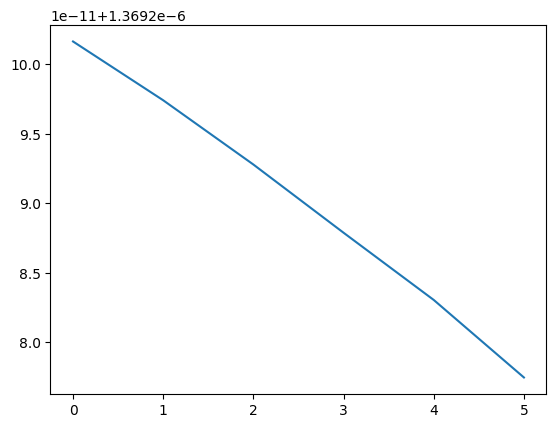

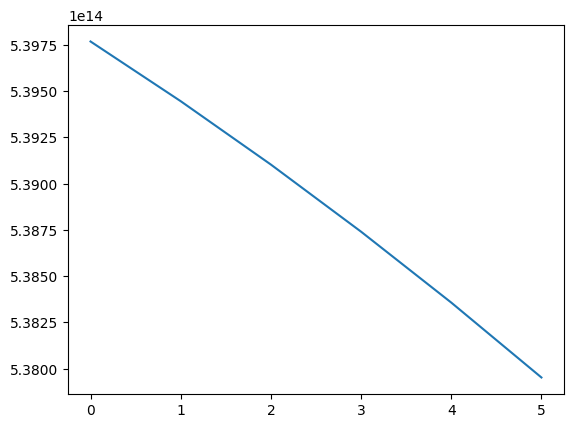

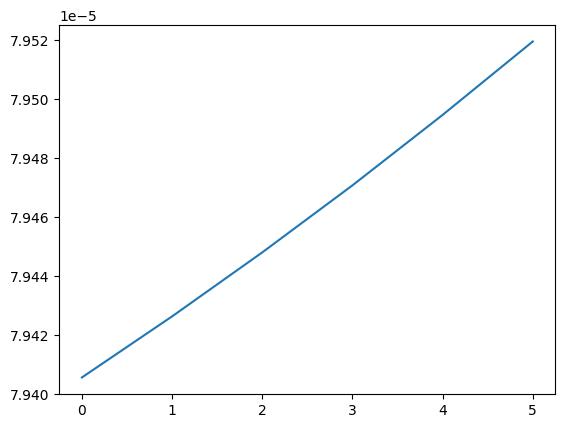

In [5]:
plt.plot( fits_r)
plt.show()
plt.plot(fits_v)
plt.show()
plt.plot(fits_k)
plt.show()